In [67]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/d/adityajn105/flickr8k'
WORKING_DIR = '/kaggle/working'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2023-02-10 09:04:17.217827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-10 09:04:18.218094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [7]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)


In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

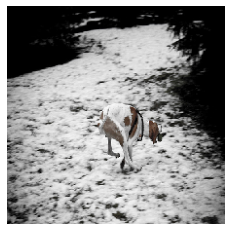

['A dog in a snowy area .', 'A spotted dog catching a ball on a snowy field .', 'A white and brown spotted dog runs along the snow to catch a ball .', 'A white dog is running fast on a trail covered by snow .', 'The brown and white dog is playing in the snow .']


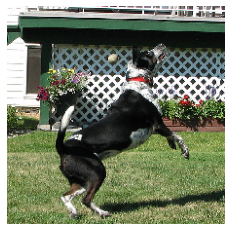

['A black and white dog is playing with a ball on a lawn .', 'A black and white dog jumps up as a ball is thrown over his head .', 'dog jumping looking up and small white ball in air passed by', 'The black and white dog is attempting to catch a ball in the garden .', 'The dog jumps up waiting to catch something being thrown .']


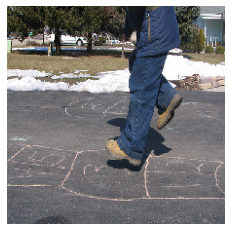

['A child in denim playing hopscotch .', 'Closeup of a pair of feet in mid jump while playing hopscotch .', 'Someone is playing hopscotch on a chalked out grid on the ground .', 'The kid is playing hopscotch .', 'The legs of a child playing hopscotch .']


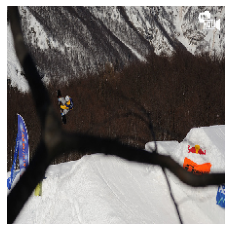

['A snowboarder dressed in yellow makes a jump .', 'a snowboarder gets air off a jump .', 'A snowboarder is doing a trick .', 'A snowboarder jumping .', 'A viewer from a helicopter watches a snowboarder below']


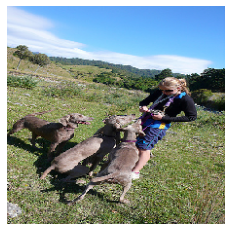

['A girl holds something while three dogs beg .', 'A woman stands in a field surrounded by three attentive gray dogs .', 'The woman and three dogs are in a field .', 'Three brown dogs are jumping up at the woman wearing blue .', 'Three grey dogs jump at a woman .']


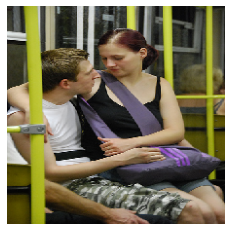

["A girl in black sitting on a man 's lap on a subway .", "A girl sitting on a man 's lap on a passenger train", 'A man and woman sit together on public transportation .', "A woman is sitting on a man 's lap on a public transportation system .", 'A woman with a ponytail dressed in jean shorts and a black tank top sitting on the lap of a man with camo shorts and a white shirt on a subway .']


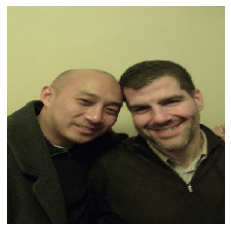

['A bald man has hand on the shoulder of another man .', 'a man puts his arm around another man as they pose for a picture', 'Two men touch their heads together and smile .', 'Two men wearing black', 'Two smiling men with their heads touching']


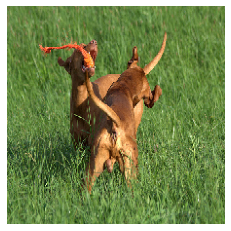

['Dogs fight in grass over toy .', '"On grass   two brown dogs tussle for orange toy ."', 'Two dogs are playing rough in a green field of grass .', 'Two dogs play with an orange toy in tall grass .', 'Two large brown dogs are playing in the grass .']


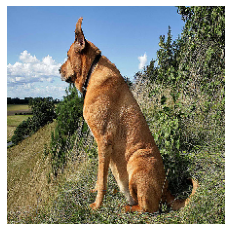

['A brown dog is sitting in some long grass .', 'A brown dog sits still on a hillside .', 'A large tan dog sits on a grassy hill .', 'A large yellow dog is sitting on a hill .', 'The dog is sitting on the side of the hill .']


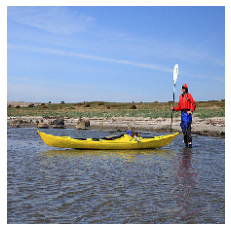

['A man holding a paddle is standing in front of a yellow kayak .', 'A man is standing in the water with a kayak .', 'A man stands next to his yellow boat in the water .', 'A person in red and blue holding a paddle in front of a yellow canoe in the water .', 'Person standing in the water by a yellow boat with an oar in their hand .']


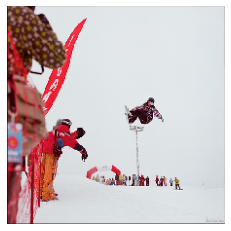

['"A group of people on the slopes   a person is skating boarding   and a bunch of people are surrounding him ."', 'Airborne snowboarder in front of a crowd .', 'A snowboarder in the air as others watch .', 'a snowboarder jumps high .', 'A snowboarder jumps while spectators watch .']


In [15]:
# before preprocess of text
path="/kaggle/input/d/adityajn105/flickr8k/Images"
l=os.listdir(path)
c=0
for i in l:
    p=path+'/'+i
    img=load_img(p,target_size=(224,224,3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    cap=str(i).split(".")
    print(mapping[cap[0]])
    c+=1
    if c>10:
        break

In [16]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [17]:
clean(mapping)

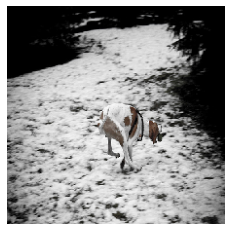

['startseq dog in snowy area endseq', 'startseq spotted dog catching ball on snowy field endseq', 'startseq white and brown spotted dog runs along the snow to catch ball endseq', 'startseq white dog is running fast on trail covered by snow endseq', 'startseq the brown and white dog is playing in the snow endseq']


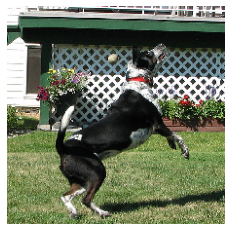

['startseq black and white dog is playing with ball on lawn endseq', 'startseq black and white dog jumps up as ball is thrown over his head endseq', 'startseq dog jumping looking up and small white ball in air passed by endseq', 'startseq the black and white dog is attempting to catch ball in the garden endseq', 'startseq the dog jumps up waiting to catch something being thrown endseq']


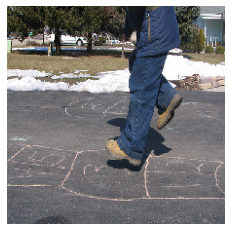

['startseq child in denim playing hopscotch endseq', 'startseq closeup of pair of feet in mid jump while playing hopscotch endseq', 'startseq someone is playing hopscotch on chalked out grid on the ground endseq', 'startseq the kid is playing hopscotch endseq', 'startseq the legs of child playing hopscotch endseq']


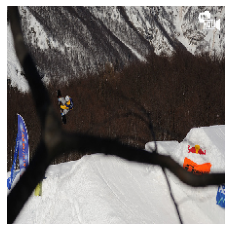

['startseq snowboarder dressed in yellow makes jump endseq', 'startseq snowboarder gets air off jump endseq', 'startseq snowboarder is doing trick endseq', 'startseq snowboarder jumping endseq', 'startseq viewer from helicopter watches snowboarder below endseq']


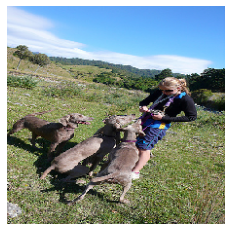

['startseq girl holds something while three dogs beg endseq', 'startseq woman stands in field surrounded by three attentive gray dogs endseq', 'startseq the woman and three dogs are in field endseq', 'startseq three brown dogs are jumping up at the woman wearing blue endseq', 'startseq three grey dogs jump at woman endseq']


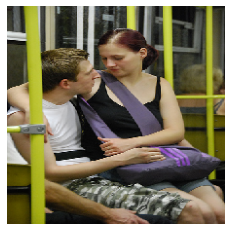

["startseq girl in black sitting on man 's lap on subway endseq", "startseq girl sitting on man 's lap on passenger train endseq", 'startseq man and woman sit together on public transportation endseq', "startseq woman is sitting on man 's lap on public transportation system endseq", 'startseq woman with ponytail dressed in jean shorts and black tank top sitting on the lap of man with camo shorts and white shirt on subway endseq']


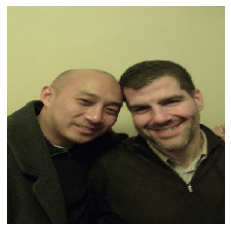

['startseq bald man has hand on the shoulder of another man endseq', 'startseq man puts his arm around another man as they pose for picture endseq', 'startseq two men touch their heads together and smile endseq', 'startseq two men wearing black endseq', 'startseq two smiling men with their heads touching endseq']


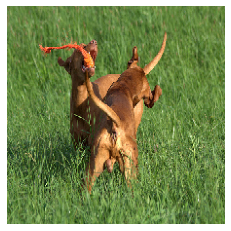

['startseq dogs fight in grass over toy endseq', 'startseq "on grass two brown dogs tussle for orange toy ." endseq', 'startseq two dogs are playing rough in green field of grass endseq', 'startseq two dogs play with an orange toy in tall grass endseq', 'startseq two large brown dogs are playing in the grass endseq']


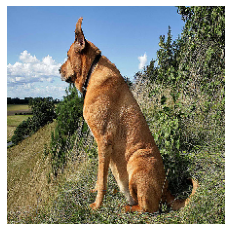

['startseq brown dog is sitting in some long grass endseq', 'startseq brown dog sits still on hillside endseq', 'startseq large tan dog sits on grassy hill endseq', 'startseq large yellow dog is sitting on hill endseq', 'startseq the dog is sitting on the side of the hill endseq']


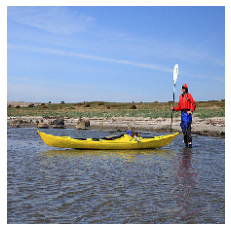

['startseq man holding paddle is standing in front of yellow kayak endseq', 'startseq man is standing in the water with kayak endseq', 'startseq man stands next to his yellow boat in the water endseq', 'startseq person in red and blue holding paddle in front of yellow canoe in the water endseq', 'startseq person standing in the water by yellow boat with an oar in their hand endseq']


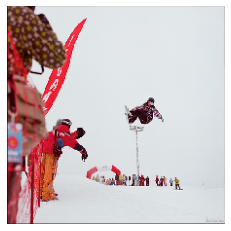

['startseq "a group of people on the slopes person is skating boarding and bunch of people are surrounding him ." endseq', 'startseq airborne snowboarder in front of crowd endseq', 'startseq snowboarder in the air as others watch endseq', 'startseq snowboarder jumps high endseq', 'startseq snowboarder jumps while spectators watch endseq']


In [18]:
# after preprocess of text
path="/kaggle/input/d/adityajn105/flickr8k/Images"
l=os.listdir(path)
c=0
for i in l:
    p=path+'/'+i
    img=load_img(p,target_size=(224,224,3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    cap=str(i).split(".")
    print(mapping[cap[0]])
    c+=1
    if c>10:
        break

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)

40455

In [21]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

8485

In [24]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [26]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

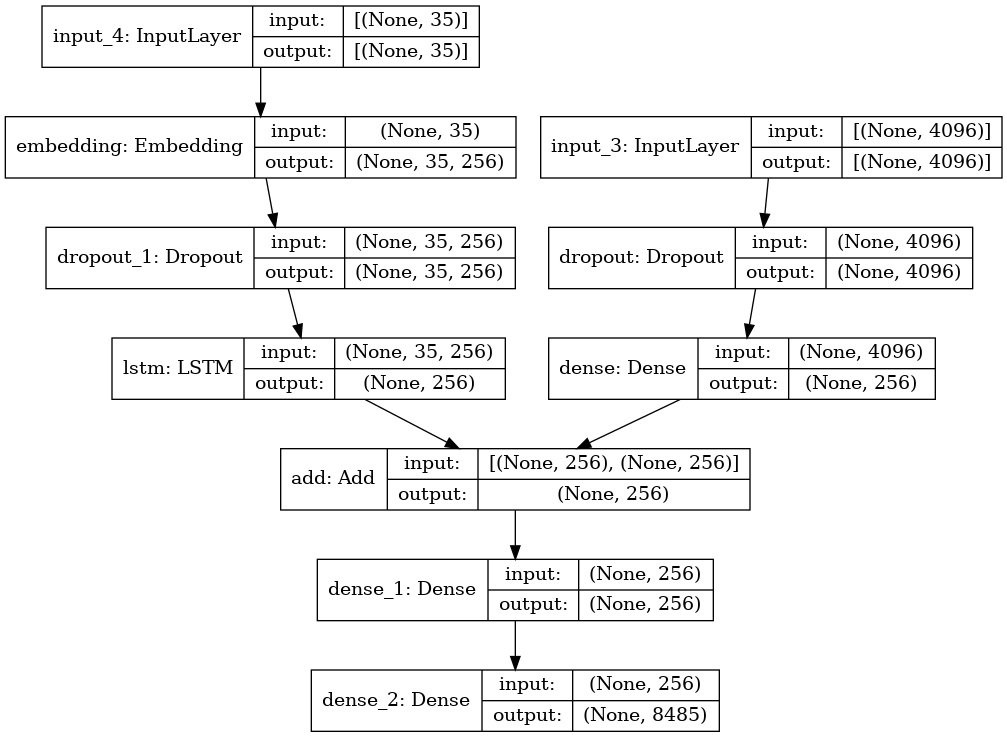

In [27]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [28]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 62s 272ms/step - loss: 2.1917


In [29]:
# save the model
model.save(WORKING_DIR+'/backup_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [32]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.526105
BLEU-2: 0.299053


In [33]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the grass endseq


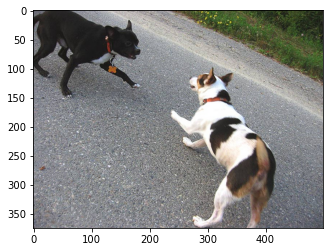

In [34]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pink dress is sitting on couch with fingerpaints in the background endseq


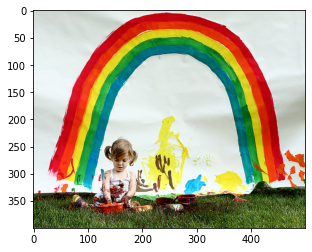

In [35]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people are skiing and skiing endseq


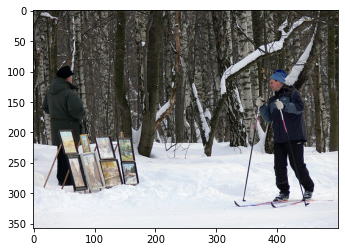

In [36]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [38]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [54]:
dir_path='/kaggle/input/test-cap-img'
val_dir=os.listdir(dir_path)
print(val_dir)

['gratisography-frog-racer-free-stock-photo-800x525.jpg', 'random-numbers-dice.jpg', 'pexels-pixabay-247502.jpg', 'sq-ea8c12ac4c2946738c7d6c3d9c45692f.jpg', 'free-stock-photos.jpg', 'house-plants-1629187361.jpg']


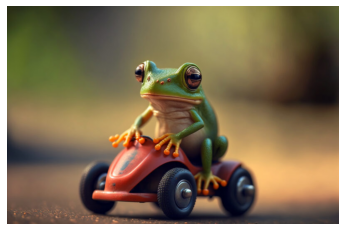

startseq the green dog is running on the green grass endseq


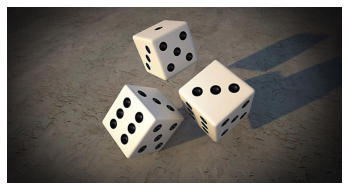

startseq man is clinging to set of sphere with drinks and drinks from his face endseq


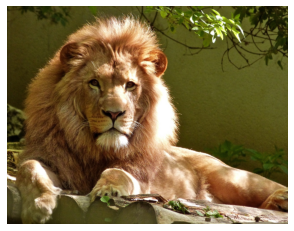

startseq two puppies are chewing their teeth on their teeth endseq


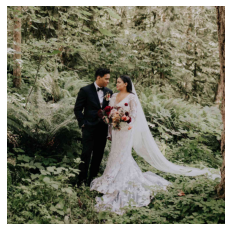

startseq two shirtless people pose for picture in front of mountain endseq


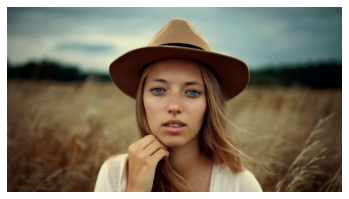

startseq young girl in pink hat and hat is standing in the sun endseq


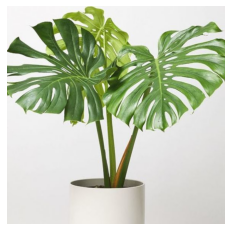

startseq person in green jacket is looking at something in the air endseq


In [68]:
dir_path='/kaggle/input/test-cap-img'
val_dir=os.listdir(dir_path)
for i in val_dir:
    image_path = os.path.join(dir_path,i)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # load image
    image = load_img(image_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image, verbose=0)
    # predict from the trained model
    print(predict_caption(model, feature, tokenizer, max_length))